# Merge lattice: experiments with 4 workers

## Create util functions

In [28]:
def add(x, y):
    x.add(y)
    return x


def union(x, y):
    x.update(y)
    return x


def intersection(x, y):
    return x.intersection(y)


def append(x, y):
    x.append(y)
    return x


def extend(x, y):
    x.extend(y)
    return x


"""
Implementation of the lattice mining algorithm based on:
https://doi.org/10.1007/978-3-319-27057-9_11 
"""

from pyspark.rdd import RDD
from pyspark.sql import DataFrame as SparkDataFrame


def get_lattice(maybe_fc):
    if isinstance(maybe_fc, RDD):
        return get_lattice_from_k_v(maybe_fc)
    else:
        return get_lattice_from_fc(maybe_fc)


def get_lattice_from_fc(fc: SparkDataFrame):
    r1 = df_to_k_v_rdd(fc)
    return _get_lattice(r1, fc.sparkSession.sparkContext)


def get_lattice_from_k_v(rdd: RDD):
    return _get_lattice(rdd, rdd.ctx)


def _get_lattice(r1, context):
    r1, attr_is_lower_dimension = key_lower_dimension(r1)
    r2 = combine_keys(r1)

    key_count = r1.countByKey()

    cc1 = r2.sortBy(lambda x: (x[0], key_count[x[0]])).cache()

    # r1.unpersist()
    # r2.unpersist()

    cc_current = cc1
    cc_next = None

    concepts_by_size = context.parallelize([])

    k = len(key_count)
    while k > 1:
        cc_next = calculate_next_cc(cc_current).cache()
        v1 = calculate_valid_concepts(cc_next, cc_current, context)
        size = len(key_count) - k + 1
        v1_set_rdd = v1.map(lambda x: (size, x))
        # concepts_by_size = concepts_by_size.fullOuterJoin(v1_set_rdd).mapValues(
        #     lambda x: x[0] if x[1] is None else x[1]
        # )
        concepts_by_size = (
            concepts_by_size.union(v1_set_rdd)
            .coalesce(context.defaultParallelism)
            .cache()
        )
        cc_current = cc_next
        k -= 1

    return (
        concepts_by_size.map(
            lambda p: (len(p[1][1]), (tuple(p[1][1]), p[1][0]))
        ).cache()
        if attr_is_lower_dimension
        else concepts_by_size
    )


def df_to_k_v_rdd(fc):
    return fc.rdd.map(lambda row: (row.object_id, row.attribute_id))


def key_lower_dimension(rdd: RDD):
    distinct_objects = rdd.keys().distinct().count()
    distinct_attributes = rdd.values().distinct().count()

    attr_is_lower_dimension = distinct_objects > distinct_attributes

    # By using tuple, this is quadratic in the amount of attributes I guess.
    if attr_is_lower_dimension:
        r1 = rdd.map(lambda row: (tuple([row[1]]), row[0]))
    else:
        r1 = rdd.map(lambda row: (tuple([row[0]]), row[1]))
    return r1, attr_is_lower_dimension


def combine_keys(r1):
    return r1.combineByKey(lambda x: set([x]), add, union)


def calculate_next_cc(cc1):
    cc1_aux = cc1.map(lambda x: (tuple([y for y in x[0][:-1]]), (x[0][-1], x[1])))

    cc2 = (
        cc1_aux.join(cc1_aux)
        .coalesce(cc1.ctx.defaultParallelism)
        .filter(lambda x: x[1][0][0] < x[1][1][0])
        .map(
            lambda x: (
                x[0] + tuple([x[1][0][0]]) + tuple([x[1][1][0]]),
                intersection(x[1][0][1], x[1][1][1]),
            )
        )
        .filter(lambda x: x[1])
    )
    return cc2.cache()


def calculate_valid_concepts(cc2, cc1, context):
    v1 = (
        cc1.map(lambda x: (tuple(sorted(x[1])), (x[0], x[1])))
        .subtractByKey(cc2.map(lambda x: (tuple(sorted(x[1])), (x[0], x[1]))))
        .map(lambda x: (x[1][0], x[1][1]))
    )
    # cc1.unpersist()
    return v1.coalesce(cc1.ctx.defaultParallelism).cache()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Create map_reduce functions

In [54]:
from pyspark.rdd import RDD


def merge_only_intents(rdd1: RDD, rdd2: RDD) -> RDD:
    """
    Args:
        rdd1 (RDD): RDD with (k, C) where k is the number of attributes in the intent, and C is a tuple (X, Y) representing a formal concept
        rdd2 (RDD): RDD with (k, C) where k is the number of attributes in the intent, and C is a tuple (X, Y) representing a formal concept
    Returns:
        the RDD resulting on the merge of rdd1 and rdd2. More specifically, it only returns the intents
    """
    # [(k, (X, Y))] -> [Y]
    rdd1 = rdd1.flatMap(lambda x: [tuple(x[1][1])]).cache()
    rdd2 = rdd2.flatMap(lambda x: [tuple(x[1][1])]).cache()

    def _merge_intents(p):
        y1, y2 = p
        intersection = set(y1).intersection(y2)
        res = [y1, y2]
        if (
            len(intersection) > 0
            and len(intersection) != len(y1)
            and len(intersection) != len(y2)
        ):
            res.append(tuple(intersection))
        return res

    res = (
        rdd1.cartesian(rdd2)
        .coalesce(rdd1.ctx.defaultParallelism)
        .flatMap(_merge_intents)
        .distinct()
    )
    return res


def merge_only_intents_with_broadcast(rdd1: RDD, rdd2: RDD) -> RDD:
    """
    Args:
        rdd1 (RDD): RDD with (k, C) where k is the number of attributes in the intent, and C is a tuple (X, Y) representing a formal concept
        rdd2 (RDD): RDD with (k, C) where k is the number of attributes in the intent, and C is a tuple (X, Y) representing a formal concept
    Returns:
        the RDD resulting on the merge of rdd1 and rdd2. More specifically, it only returns the intents
    """
    # [(k, (X, Y))] -> [Y]
    rdd1 = rdd1.flatMap(lambda x: [tuple(x[1][1])]).cache()
    rdd2 = rdd2.flatMap(lambda x: [tuple(x[1][1])]).cache()
    rdd_1_size = rdd1.countApprox(300)
    rdd_2_size = rdd2.countApprox(300)
    if rdd_2_size < rdd_1_size:
        broadcasted_cs = rdd2.ctx.broadcast(rdd2.collect())
    else:
        broadcasted_cs = rdd1.ctx.broadcast(rdd1.collect())
    the_rest = rdd1.flatMap(for_each_concept(broadcasted_cs))
    return the_rest.distinct()


def for_each_concept(broadcasted_cs):
    def f(concept):
        # if rdd2.isEmpty() or rdd1.isEmpty():
        res = []
        c1 = concept
        res.append(c1)
        for c2 in broadcasted_cs.value:
            res.append(c2)
            intersection = set(c1).intersection(c2)
            if len(intersection) > 0:
                res.extend([tuple(intersection)])
        return res

    return f


def merge_without_union(rdd1: RDD, rdd2: RDD) -> RDD:
    # [(k, (X, Y))] -> [(Y, X)]
    rdd1 = rdd1.flatMap(lambda x: [(tuple(x[1][1]), x[1][0])]).cache()
    rdd2 = rdd2.flatMap(lambda x: [(tuple(x[1][1]), x[1][0])]).cache()
    # rdd1.union(rdd2).coalesce(rdd1.ctx.defaultParallelism).reduceByKey()

    def _merge_concepts(p):
        c1, c2 = p
        x1, x2 = c1[1], c2[1]
        y1, y2 = c1[0], c2[0]
        intersection = sorted(list(set(y1).intersection(y2)))
        res = []
        # this means they are exactly the same set
        if len(intersection) == 0:
            if set(y1) != set(y2):
                res.extend([c1, c2])
            else:
                res.append(c1)
        elif len(intersection) == len(y1) == len(y2):
            new_extent = list(x1)
            new_extent.extend(x2)
            res.append((y1, tuple(new_extent)))
        else:
            new_extent = list(x1)
            new_extent.extend(x2)
            if len(intersection) == len(y1):
                res.extend([c2, (tuple(intersection), new_extent)])
            elif len(intersection) == len(y2):
                res.extend([c1, (tuple(intersection), new_extent)])
            else:
                # here new_extent could be larger
                res.extend([c1, c2, (tuple(intersection), new_extent)])
        return res

    res = (
        rdd1.cartesian(rdd2)
        .coalesce(rdd1.ctx.defaultParallelism * 2)
        .flatMap(_merge_concepts)
        .map(lambda p: (tuple(sorted(p[0])), p[1]))
        .reduceByKey(lambda c1, c2: c1 if len(c1) > len(c2) else c2)
        .map(lambda p: (tuple(p[1]), p[0]))
    )

    return res


def merge_with_union(p_rdd1: RDD, p_rdd2: RDD) -> RDD:
    # [(k, (X, Y))] -> [(Y, X)]
    rdd1 = p_rdd1.flatMap(lambda x: [(tuple(x[1][1]), x[1][0])]).cache()
    rdd2 = p_rdd2.flatMap(lambda x: [(tuple(x[1][1]), x[1][0])]).cache()
    all_intents = (
        rdd1.union(rdd2)
        .coalesce(rdd1.ctx.defaultParallelism * 3)
        .reduceByKey(lambda c1, c2: tuple(set(c1).union(c2)))
    ).cache()

    attributes_1 = rdd1.flatMap(lambda p: p[0]).distinct()
    attributes_2 = rdd2.flatMap(lambda p: p[0]).distinct()
    only_attr_1 = attributes_1.collect()
    only_attr_2 = attributes_2.collect()
    intersection = set(only_attr_1).intersection(only_attr_2)
    broadcasted_intersection = rdd1.ctx.broadcast(intersection)
    filtered_rdd1 = rdd1.filter(
        lambda p: len(broadcasted_intersection.value.intersection(set(p[0]))) != 0
    ).cache()
    filtered_rdd2 = rdd2.filter(
        lambda p: len(broadcasted_intersection.value.intersection(set(p[0]))) != 0
    ).cache()

    def _merge_concepts(p):
        c1, c2 = p
        x1, x2 = c1[1], c2[1]
        y1, y2 = c1[0], c2[0]
        intersection = set(y1).intersection(y2)
        res = []
        if len(intersection) != 0:
            new_extent = list(x1)
            new_extent.extend(x2)
            # here new_extent could be larger
            res.extend([(tuple(sorted(list(intersection))), new_extent)])
        return res

    res = (
        filtered_rdd1.cartesian(filtered_rdd2)
        .coalesce(rdd1.ctx.defaultParallelism * 3)
        .flatMap(_merge_concepts)
        .union(all_intents)
        .coalesce(rdd1.ctx.defaultParallelism * 3)
        .map(lambda p: (tuple(sorted(p[0])), p[1]))
        .reduceByKey(lambda c1, c2: c1 if len(c1) > len(c2) else c2)
        .map(lambda p: (tuple(p[1]), p[0]))
        .cache()
    )

    return res

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Functions for experiments

In [7]:
import time
def measure_time(f):
    def wrap(*args, **kwargs):
        ts = time.time()
        res = f(*args, **kwargs)
        tf = time.time()
        elapsed_time = tf - ts
        print(f'{f.__name__} execution_time: {elapsed_time*1000}ms')
        return res
    return wrap

@measure_time
def collect_intents(merged_intents_rdd, message=""):
    print(message, end="")
    return merged_intents_rdd.collect()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Start testing with the real world cases

## Only intents

In [4]:
SR_DATA_SOURCE = "s3://ramshell-bucket-123/source/"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
def test_only_intents(resort, suffix=""):
    all_data = spark.read.csv(f"{SR_DATA_SOURCE}experiment_latest_k_orders_ctx_resort_{resort}{suffix}.csv", header=True)
    collected_data = all_data.collect()
    all_pairs = [(row[0], row[1]) for row in collected_data]
    all_data_2 = spark.read.csv(f"{SR_DATA_SOURCE}experiment_snapshot_orders_ctx_resort_{resort}{suffix}.csv", header=True)
    collected_data_2 = all_data_2.collect()
    all_pairs_2 = [(row[0], row[1]) for row in collected_data_2]
    
    rdd1 = sc.parallelize(all_pairs)
    rdd2 = sc.parallelize(all_pairs_2)

    rdd1_lattice = get_lattice_from_k_v(rdd1)
    rdd2_lattice = get_lattice_from_k_v(rdd2)
    _l1 = rdd1_lattice.collect()
    _l2 = rdd2_lattice.collect()

    merged_intents_2_rdd = merge_only_intents_with_broadcast(rdd1_lattice, rdd2_lattice)
    merged_intents_1_rdd = merge_only_intents(rdd1_lattice, rdd2_lattice)

    rdd3 = rdd1.union(rdd2).coalesce(rdd2.ctx.defaultParallelism)
    rdd3_lattice = get_lattice_from_k_v(rdd3)

    print(f"Test from resort {resort}{suffix}")
    print("  ", end="")
    merged_intents_1 = collect_intents(merged_intents_1_rdd)
    print("  ", end="")
    merged_intents_2 = collect_intents(merged_intents_2_rdd)
    print("  ", end="")
    merged_intents_3 = collect_intents(rdd3_lattice.map(lambda p: p[1][1]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
test_only_intents(362)
test_only_intents(596)
test_only_intents(125)
test_only_intents(308)
test_only_intents(422)
test_only_intents(362, "_1_1")
test_only_intents(596, "_1_1")
test_only_intents(125, "_1_1")
test_only_intents(308, "_1_1")
test_only_intents(422, "_1_1")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test from resort 362
  collect_intents execution_time: 453.40538024902344ms
  collect_intents execution_time: 226.19366645812988ms
  collect_intents execution_time: 40194.83017921448ms
Test from resort 596
  collect_intents execution_time: 475.4650592803955ms
  collect_intents execution_time: 410.10212898254395ms
  collect_intents execution_time: 48538.455963134766ms
Test from resort 125
  collect_intents execution_time: 4733.488082885742ms
  collect_intents execution_time: 2654.01029586792ms
  collect_intents execution_time: 64765.83766937256ms
Test from resort 308
  collect_intents execution_time: 1412.3175144195557ms
  collect_intents execution_time: 790.1661396026611ms
  collect_intents execution_time: 57453.421115875244ms
Test from resort 422
  collect_intents execution_time: 5441.831827163696ms
  collect_intents execution_time: 3097.217798233032ms
  collect_intents execution_time: 76717.53144264221ms
Test from resort 362_1_1
  collect_intents execution_time: 398.6637592315674ms
 

## All concepts

In [ ]:
def test_concepts_with_cartesian(resort, suffix=""):
    all_data = spark.read.csv(f"{SR_DATA_SOURCE}experiment_latest_k_orders_ctx_resort_{resort}{suffix}.csv", header=True)
    collected_data = all_data.collect()
    all_pairs = [(row[0], row[1]) for row in collected_data]
    all_data_2 = spark.read.csv(f"{SR_DATA_SOURCE}experiment_snapshot_orders_ctx_resort_{resort}{suffix}.csv", header=True)
    collected_data_2 = all_data_2.collect()
    all_pairs_2 = [(row[0], row[1]) for row in collected_data_2]
    
    rdd1 = sc.parallelize(all_pairs)
    rdd2 = sc.parallelize(all_pairs_2)

    rdd1_lattice = get_lattice_from_k_v(rdd1)
    rdd2_lattice = get_lattice_from_k_v(rdd2)
    _l1 = rdd1_lattice.collect()
    _l2 = rdd2_lattice.collect()

    merged_intents_2_rdd = merge_without_union(rdd1_lattice, rdd2_lattice)
    merged_intents_1_rdd = merge_with_union(rdd1_lattice, rdd2_lattice)


    print(f"Test from resort {resort}{suffix}")
    print("  full cartesian product: ", end="")
    merged_intents_1 = collect_intents(merged_intents_1_rdd)
    print("  considering only attributes in intersection: ", end="")
    merged_intents_2 = collect_intents(merged_intents_2_rdd)

## All concepts with Cartesian product (including extent)

In [11]:
def test_concepts_with_cartesian(resort, suffix=""):
    all_data = spark.read.csv(f"{SR_DATA_SOURCE}experiment_latest_k_orders_ctx_resort_{resort}{suffix}.csv", header=True)
    collected_data = all_data.collect()
    all_pairs = [(row[0], row[1]) for row in collected_data]
    all_data_2 = spark.read.csv(f"{SR_DATA_SOURCE}experiment_snapshot_orders_ctx_resort_{resort}{suffix}.csv", header=True)
    collected_data_2 = all_data_2.collect()
    all_pairs_2 = [(row[0], row[1]) for row in collected_data_2]
    
    rdd1 = sc.parallelize(all_pairs)
    rdd2 = sc.parallelize(all_pairs_2)

    rdd1_lattice = get_lattice_from_k_v(rdd1)
    rdd2_lattice = get_lattice_from_k_v(rdd2)
    _l1 = rdd1_lattice.collect()
    _l2 = rdd2_lattice.collect()

    merged_intents_2_rdd = merge_without_union(rdd1_lattice, rdd2_lattice)
    merged_intents_1_rdd = merge_with_union(rdd1_lattice, rdd2_lattice)


    print(f"Test from resort {resort}{suffix}")
    print("  full cartesian product: ", end="")
    merged_intents_1 = collect_intents(merged_intents_1_rdd)
    print("  considering only attributes in intersection: ", end="")
    merged_intents_2 = collect_intents(merged_intents_2_rdd)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
test_concepts_with_cartesian(362)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test from resort 362
  full cartesian product: collect_intents execution_time: 764.1904354095459ms
  considering only attributes in intersection: collect_intents execution_time: 613.868236541748ms

In [56]:
test_concepts_with_cartesian(596)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test from resort 596
  full cartesian product: collect_intents execution_time: 1636.667251586914ms
  considering only attributes in intersection: collect_intents execution_time: 704.3447494506836ms

In [57]:
test_concepts_with_cartesian(125)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test from resort 125
  full cartesian product: collect_intents execution_time: 6304.638385772705ms
  considering only attributes in intersection: collect_intents execution_time: 6833.008289337158ms

In [58]:
test_concepts_with_cartesian(308)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test from resort 308
  full cartesian product: collect_intents execution_time: 3327.1398544311523ms
  considering only attributes in intersection: collect_intents execution_time: 2445.692300796509ms

In [59]:
test_concepts_with_cartesian(422)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test from resort 422
  full cartesian product: collect_intents execution_time: 28092.634439468384ms
  considering only attributes in intersection: collect_intents execution_time: 10864.885568618774ms

In [60]:
test_concepts_with_cartesian(362, "_1_1")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test from resort 362_1_1
  full cartesian product: collect_intents execution_time: 758.6033344268799ms
  considering only attributes in intersection: collect_intents execution_time: 341.17627143859863ms

In [61]:
test_concepts_with_cartesian(596, "_1_1")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test from resort 596_1_1
  full cartesian product: collect_intents execution_time: 2083.815574645996ms
  considering only attributes in intersection: collect_intents execution_time: 970.1123237609863ms

In [62]:
test_concepts_with_cartesian(125, "_1_1")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test from resort 125_1_1
  full cartesian product: collect_intents execution_time: 10963.559627532959ms
  considering only attributes in intersection: collect_intents execution_time: 10699.086666107178ms

In [63]:
test_concepts_with_cartesian(308, "_1_1")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test from resort 308_1_1
  full cartesian product: collect_intents execution_time: 9321.633100509644ms
  considering only attributes in intersection: collect_intents execution_time: 8682.173013687134ms

In [64]:
test_concepts_with_cartesian(422, "_1_1")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test from resort 422_1_1
  full cartesian product: collect_intents execution_time: 56758.89754295349ms
  considering only attributes in intersection: collect_intents execution_time: 17445.918560028076ms

# Plot results

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tikzplotlib


/tmp/ipykernel_66726/3960886100.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## For 2 workers

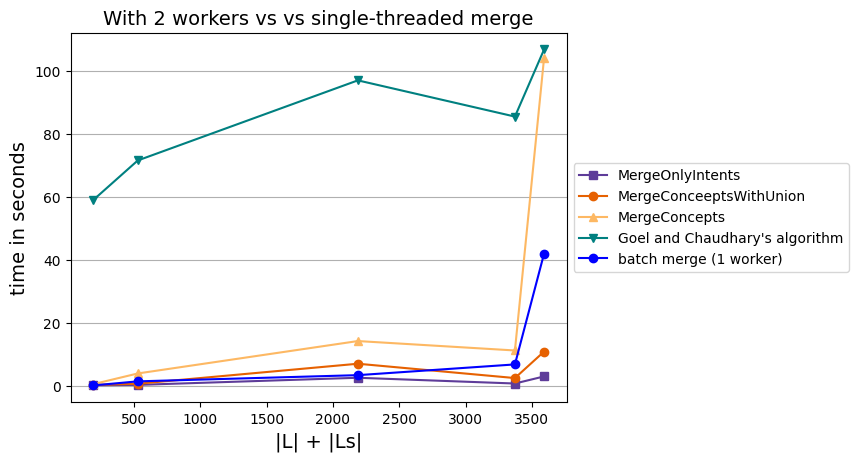

In [3]:
l_plus_ls_size = [118 + 75, 367 + 162, 1341 + 847, 3272 + 100, 3199 + 393]
time_passed_2_workers_merge_intents_only = [.170, .281, 2.543, .714, 2.973]
time_passed_2_workers_merge_concepts_with_union = [.288, .644, 6.997, 2.447, 10.864]
time_passed_2_workers_merge_concepts = [.512, 3.907, 14.200, 11.205, 104.219]
time_passed_for_merge = [x for x in [.11, 1.4, 3.37, 6.78, 42]]
time_passed_for_goel_and_chaudhary = [x for x in [58.963, 71.544, 96.975, 85.475, 106.803]]

fig, ax = plt.subplots()

ax.plot(l_plus_ls_size, time_passed_2_workers_merge_intents_only, color='#5e3c99', marker='s', label="MergeOnlyIntents")
ax.plot(l_plus_ls_size, time_passed_2_workers_merge_concepts_with_union, color='#e66101', marker='o', label="MergeConceeptsWithUnion")
ax.plot(l_plus_ls_size, time_passed_2_workers_merge_concepts, color='#fdb863', marker='^', label="MergeConcepts")
plt.plot(l_plus_ls_size, time_passed_for_goel_and_chaudhary, color='teal', marker='v', label="Goel and Chaudhary's algorithm")
plt.plot(l_plus_ls_size, time_passed_for_merge, color='blue', marker='o', label="batch merge (1 worker)")
ax.set_title('With 2 workers vs vs single-threaded merge', fontsize=14)
ax.set_xlabel('|L| + |Ls|', fontsize=14)
ax.set_ylabel('time in seconds', fontsize=14)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(axis='y')

tikzplotlib.save("sum_of_param_sizes_vs_seconds_2_workers_1_05.tex")
plt.show()

# Annotation 
# ax.annotate('E_1', xy =(118 + 75, 6), 
#                 xytext =(118 + 75, 20),  
#                 arrowprops = dict(facecolor ='white', 
#                                   shrink = 0.05),) 

# ax.annotate('E_2', xy =(367 + 162, 6), 
#                 xytext =(367 + 162, 20),  
#                 arrowprops = dict(facecolor ='white', 
#                                   shrink = 0.05),) 

# ax.annotate('E_3', xy =(1341 + 847, 20), 
#                 xytext =(1341 + 847, 35),  
#                 arrowprops = dict(facecolor ='white', 
#                                     shrink = 0.05),)


# ax.annotate('E_4', xy =(3272 + 100 - 20, 15), 
#                 xytext =(3272 + 100 - 300, 35),  
#                 arrowprops = dict(facecolor ='white', 
#                                     shrink = 0.05),)


# ax.annotate('E_4', xy =(3272 + 100 - 20, 15), 
#                 xytext =(3272 + 100 - 300, 35),  
#                 arrowprops = dict(facecolor ='white', 
#                                     shrink = 0.05),)

# ax.annotate('E_5', xy =(3199 + 393, 105), 
#                 xytext =(3199 + 393 - 800, 105),  
#                 arrowprops = dict(facecolor ='white', 
#                                     shrink = 0.05),) 



## For 3 workers

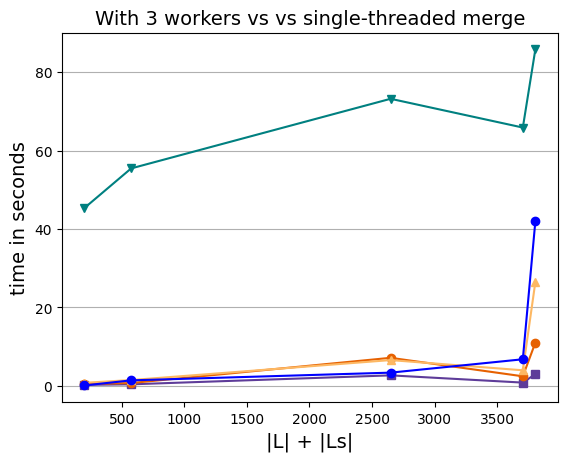

In [96]:
l_plus_ls_size = [118 + 85, 367 + 209, 1341 + 1307, 3272 + 432, 3199 + 605]
time_passed_3_workers_merge_intents_only = [.260, .391, 2.676, .830, 2.997]
time_passed_3_workers_merge_concepts_with_union = [.468, .719, 7.151, 2.436, 11.020]
time_passed_3_workers_merge_concepts = [.770, 1.479, 6.574, 3.969, 26.491]
time_passed_for_merge = [x for x in [.11, 1.4, 3.37, 6.78, 42]]
time_passed_3_workers_for_goel_and_chaudhary = [x for x in [45.375, 55.471, 73.229, 65.891, 85.824]]

fig, ax = plt.subplots()

ax.plot(l_plus_ls_size, time_passed_3_workers_merge_intents_only, color='#5e3c99', marker='s', label="MergeOnlyIntents")
ax.plot(l_plus_ls_size, time_passed_3_workers_merge_concepts_with_union, color='#e66101', marker='o', label="MergeConceeptsWithUnion")
ax.plot(l_plus_ls_size, time_passed_3_workers_merge_concepts, color='#fdb863', marker='^', label="MergeConcepts")
plt.plot(l_plus_ls_size, time_passed_3_workers_for_goel_and_chaudhary, color='teal', marker='v', label="Goel and Chaudhary's algorithm")
plt.plot(l_plus_ls_size, time_passed_for_merge, color='blue', marker='o', label="batch merge (1 worker)")
ax.set_title('With 3 workers vs vs single-threaded merge', fontsize=14)
ax.set_xlabel('|L| + |Ls|', fontsize=14)
ax.set_ylabel('time in seconds', fontsize=14)
plt.grid(axis='y')
#ax.set_ylim(-2, 80)

tikzplotlib.save("sum_of_param_sizes_vs_seconds_3_workers_1_05.tex")
plt.show()

## For 4 workers

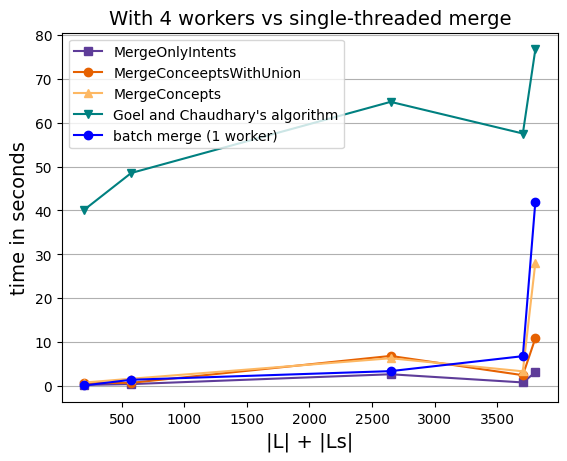

In [4]:
l_plus_ls_size = [118 + 85, 367 + 209, 1341 + 1307, 3272 + 432, 3199 + 605]
time_passed_4_workers_merge_intents_only = [.226, .410, 2.654, .790, 3.097]
time_passed_4_workers_merge_concepts_with_union = [.613, .704, 6.833, 2.445, 10.864]
time_passed_4_workers_merge_concepts = [.764, 1.636, 6.304, 3.327, 28.092]
time_passed_for_merge = [x for x in [.11, 1.4, 3.37, 6.78, 42]]
time_passed_4_workers_for_goel_and_chaudhary = [x for x in [40.194, 48.538, 64.765, 57.543, 76.717]]

fig, ax = plt.subplots()

ax.plot(l_plus_ls_size, time_passed_4_workers_merge_intents_only, color='#5e3c99', marker='s', label="MergeOnlyIntents")
ax.plot(l_plus_ls_size, time_passed_4_workers_merge_concepts_with_union, color='#e66101', marker='o', label="MergeConceeptsWithUnion")
ax.plot(l_plus_ls_size, time_passed_4_workers_merge_concepts, color='#fdb863', marker='^', label="MergeConcepts")
plt.plot(l_plus_ls_size, time_passed_4_workers_for_goel_and_chaudhary, color='teal', marker='v', label="Goel and Chaudhary's algorithm")
plt.plot(l_plus_ls_size, time_passed_for_merge, color='blue', marker='o', label="batch merge (1 worker)")
ax.set_title('With 4 workers vs single-threaded merge', fontsize=14)
ax.set_xlabel('|L| + |Ls|', fontsize=14)
ax.set_ylabel('time in seconds', fontsize=14)
plt.legend(loc="upper left")
plt.grid(axis='y')
#ax.set_ylim(-2, 80)

tikzplotlib.save("sum_of_param_sizes_vs_seconds_4_workers_1_05.tex")
plt.show()

# For ratio 1:1

## 2 workers

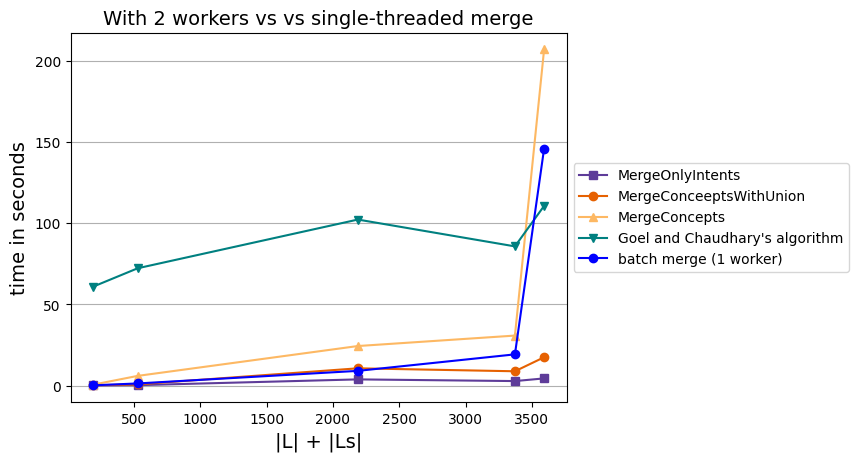

In [9]:
l_plus_ls_size = [118 + 75, 367 + 162, 1341 + 847, 3272 + 100, 3199 + 393]
time_passed_2_workers_merge_intents_only = [.179, .334, 3.892, 2.855, 4.502]
time_passed_2_workers_merge_concepts_with_union = [.270, .840, 10.714, 8.888, 17.525]
time_passed_2_workers_merge_concepts = [.659, 6.058, 24.428, 30.865, 207.026]
time_passed_for_merge = [x for x in [.229, 1.4, 9.14, 19.3, 2 * 60 + 26]]
time_passed_for_goel_and_chaudhary = [x for x in [61.000, 72.322, 102.285, 85.775, 110.709]]

fig, ax = plt.subplots()

ax.plot(l_plus_ls_size, time_passed_2_workers_merge_intents_only, color='#5e3c99', marker='s', label="MergeOnlyIntents")
ax.plot(l_plus_ls_size, time_passed_2_workers_merge_concepts_with_union, color='#e66101', marker='o', label="MergeConceeptsWithUnion")
ax.plot(l_plus_ls_size, time_passed_2_workers_merge_concepts, color='#fdb863', marker='^', label="MergeConcepts")
plt.plot(l_plus_ls_size, time_passed_for_goel_and_chaudhary, color='teal', marker='v', label="Goel and Chaudhary's algorithm")
plt.plot(l_plus_ls_size, time_passed_for_merge, color='blue', marker='o', label="batch merge (1 worker)")
ax.set_title('With 2 workers vs vs single-threaded merge', fontsize=14)
ax.set_xlabel('|L| + |Ls|', fontsize=14)
ax.set_ylabel('time in seconds', fontsize=14)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(axis='y')

tikzplotlib.save("sum_of_param_sizes_vs_seconds_2_workers_1_1.tex")
plt.show()

## 3 workers

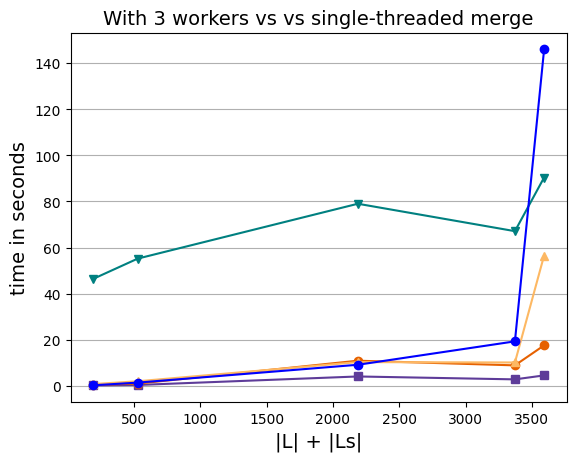

In [10]:
l_plus_ls_size = [118 + 75, 367 + 162, 1341 + 847, 3272 + 100, 3199 + 393]
time_passed_3_workers_merge_intents_only = [.176, .371, 4.062, 2.802, 4.524]
time_passed_3_workers_merge_concepts_with_union = [.429, .962, 10.907, 8.880, 17.560]
time_passed_3_workers_merge_concepts = [.751, 1.982, 10.297, 10.132, 56.551]
time_passed_for_merge = [x for x in [.229, 1.4, 9.14, 19.3, 2 * 60 + 26]]
time_passed_for_goel_and_chaudhary = [x for x in [46.418, 55.223, 79.020, 67.121, 90.413]]

fig, ax = plt.subplots()

ax.plot(l_plus_ls_size, time_passed_3_workers_merge_intents_only, color='#5e3c99', marker='s', label="MergeOnlyIntents")
ax.plot(l_plus_ls_size, time_passed_3_workers_merge_concepts_with_union, color='#e66101', marker='o', label="MergeConceeptsWithUnion")
ax.plot(l_plus_ls_size, time_passed_3_workers_merge_concepts, color='#fdb863', marker='^', label="MergeConcepts")
plt.plot(l_plus_ls_size, time_passed_for_goel_and_chaudhary, color='teal', marker='v', label="Goel and Chaudhary's algorithm")
plt.plot(l_plus_ls_size, time_passed_for_merge, color='blue', marker='o', label="batch merge (1 worker)")
ax.set_title('With 3 workers vs vs single-threaded merge', fontsize=14)
ax.set_xlabel('|L| + |Ls|', fontsize=14)
ax.set_ylabel('time in seconds', fontsize=14)
plt.grid(axis='y')

tikzplotlib.save("sum_of_param_sizes_vs_seconds_3_workers_1_1.tex")
plt.show()

## 4 workers

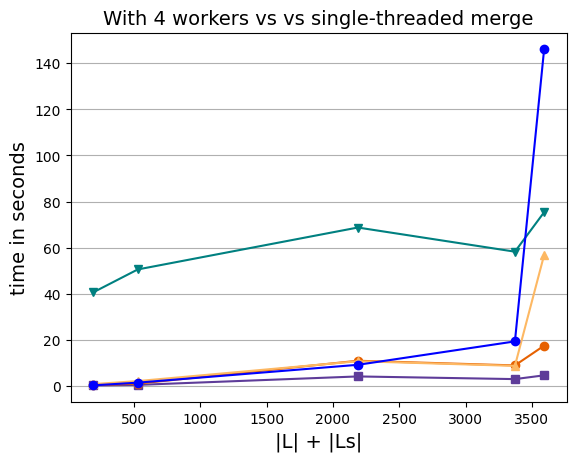

In [11]:
l_plus_ls_size = [118 + 75, 367 + 162, 1341 + 847, 3272 + 100, 3199 + 393]
time_passed_4_workers_merge_intents_only = [.197, .429, 4.096, 2.938, 4.574]
time_passed_4_workers_merge_concepts_with_union = [.341, .970, 10.907, 8.880, 17.445]
time_passed_4_workers_merge_concepts = [.758, 2.083, 10.699, 8.682, 56.758]
time_passed_for_merge = [x for x in [.229, 1.4, 9.14, 19.3, 2 * 60 + 26]]
time_passed_for_goel_and_chaudhary = [x for x in [40.584, 50.526, 68.715, 58.234, 75.348]]

fig, ax = plt.subplots()

ax.plot(l_plus_ls_size, time_passed_4_workers_merge_intents_only, color='#5e3c99', marker='s', label="MergeOnlyIntents")
ax.plot(l_plus_ls_size, time_passed_4_workers_merge_concepts_with_union, color='#e66101', marker='o', label="MergeConceeptsWithUnion")
ax.plot(l_plus_ls_size, time_passed_4_workers_merge_concepts, color='#fdb863', marker='^', label="MergeConcepts")
plt.plot(l_plus_ls_size, time_passed_for_goel_and_chaudhary, color='teal', marker='v', label="Goel and Chaudhary's algorithm")
plt.plot(l_plus_ls_size, time_passed_for_merge, color='blue', marker='o', label="batch merge (1 worker)")
ax.set_title('With 4 workers vs vs single-threaded merge', fontsize=14)
ax.set_xlabel('|L| + |Ls|', fontsize=14)
ax.set_ylabel('time in seconds', fontsize=14)
plt.grid(axis='y')

tikzplotlib.save("sum_of_param_sizes_vs_seconds_4_workers_1_1.tex")
plt.show()